# Multiclass Models Training for BABE Dataset 

## Imports, libraries and rusable functions

In [1]:
# General Utilities
import os
import re
import time
import ast
import warnings
import math
import copy
import json
from collections import Counter
from tqdm.notebook import tqdm

# Data Manipulation
import pandas as pd
import numpy as np
import csv

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_importance

# Machine Learning Utilities
import xgboost
import tensorflow as tf
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, f1_score
# import scikitplot as skplt  # Uncomment if scikit-plot is installed and needed
from tabulate import tabulate

# Transformers and Hugging Face Utilities
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, XLMRobertaForSequenceClassification,
    DistilBertConfig, DistilBertModel, DistilBertForSequenceClassification, CamembertForSequenceClassification, RobertaForSequenceClassification,
    AdamW, get_linear_schedule_with_warmup, TrainerCallback, EarlyStoppingCallback, Trainer, TrainingArguments
)
from datasets import load_dataset, DatasetDict, Dataset

# Experiment Tracking
#import wandb  # Uncomment if using Weights & Biases for experiment tracking


In [2]:
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

GPU: NVIDIA GeForce RTX 4070 Ti SUPER is available.
cuda


In [60]:
# Reusable Function Definitions

def custom_label(row):
    """
    Determines the label for a given row of the dataset based on specific criteria.
    
    Args:
        row (pd.Series): A row from a DataFrame.
        
    Returns:
        str: Custom label string based on the given logic.
    """
    if row['type'] == 'center' or row['label_bias'] == 'Non-biased':
        return 'Non-biased'
    else:
        return f"{row['type']}-Biased"

def load_and_prepare_binary_calssification_data(file_paths):
    """
    Load data from specified file paths, preprocess, and create train, validation, and test splits.
    
    Args:
        file_paths (list): List of file paths to load and concatenate.
        
    Returns:
        DatasetDict: A dictionary containing training, validation, and test datasets.
    """
    data = pd.concat([pd.read_excel(path) for path in file_paths])    
    data = data[['text','label_bias']]
    data = data[data['label_bias'] != 'No agreement']
    data['label_bias'] = data['label_bias'].map({'Non-biased': 1, 'Biased': 0})
    data = data.rename(columns={'label_bias': 'labels'})
    
    # Split data
    train_temp, test = train_test_split(data, test_size=0.10, random_state=42, stratify=data['labels'])
    train, val = train_test_split(train_temp, test_size=1/9, random_state=42, stratify=train_temp['labels'])

    # Convert to Hugging Face datasets
    return DatasetDict({
        'train': Dataset.from_pandas(train, preserve_index=False),
        'val': Dataset.from_pandas(val, preserve_index=False),
        'test': Dataset.from_pandas(test, preserve_index=False)
    })    
    
def load_and_prepare_data(file_paths):
    """
    Load data from specified file paths, preprocess, and create train, validation, and test splits.
    
    Args:
        file_paths (list): List of file paths to load and concatenate.
        
    Returns:
        DatasetDict: A dictionary containing training, validation, and test datasets.
    """
    data = pd.concat([pd.read_excel(path) for path in file_paths])
    data['labels'] = data.apply(custom_label, axis=1)
    data.dropna(subset=['type'], inplace=True)
    data = data[data.label_bias != 'No agreement']
    label_mapping = {'Non-biased': 0, 'left-Biased': 1, 'right-Biased': 2}
    data['labels'] = data['labels'].replace(label_mapping)
    data = data[['text', 'labels']]

    # Split data
    train_temp, test = train_test_split(data, test_size=0.10, random_state=42, stratify=data['labels'])
    train, val = train_test_split(train_temp, test_size=1/9, random_state=42, stratify=train_temp['labels'])

    # Convert to Hugging Face datasets
    return DatasetDict({
        'train': Dataset.from_pandas(train, preserve_index=False),
        'val': Dataset.from_pandas(val, preserve_index=False),
        'test': Dataset.from_pandas(test, preserve_index=False)
    })
    
def ensemble_score(outputs, true_labels):
    """
    Compute the ensemble score by majority voting from a list of model outputs.
    
    Args:
        outputs (list): List of model outputs containing predictions.
        true_labels (array): Actual labels for the evaluation dataset.
    
    Returns:
        tuple: Tuple containing the final predicted labels and the accuracy.
    """
    final_labels = []
    # Loop through predictions to compute majority vote
    for preds in zip(*[output.predictions for output in outputs]):
        votes = [np.argmax(pred) for pred in preds]
        final_labels.append(max(set(votes), key=votes.count))
    
    # Calculate accuracy
    acc = accuracy_score(true_labels, final_labels)
    # Calculate F1-score with default 'macro' average to consider label imbalance
    f1 = f1_score(true_labels, final_labels, average='macro')
    
    return final_labels, acc, f1

def ensemble_score_total_sum(outputs, true_labels, weights=None):
    """
    Compute the ensemble score by summing predictions from a list of model outputs before deciding the final class,
    with an option to weight predictions differently.
    
    Args:
        outputs (list): List of model outputs containing predictions.
        true_labels (array): Actual labels for the evaluation dataset.
        weights (list, optional): List of weights corresponding to each model output. Default is None, which
                                  assigns equal weight to each model.
    
    Returns:
        tuple: Tuple containing the final predicted labels and the accuracy.
    """
    final_labels = []

    # Set equal weights if none are provided
    if weights is None:
        weights = [1] * len(outputs)

    # Ensure the weights and outputs have the same length
    if len(weights) != len(outputs):
        raise ValueError("The number of weights must match the number of outputs")

    # Sum the predictions weighted and take the argmax
    for preds in zip(*[output.predictions for output in outputs]):
        # Apply weights to each model's predictions before summing
        weighted_preds = np.sum([p*w for p, w in zip(preds, weights)], axis=0)
        final_labels.append(np.argmax(weighted_preds))
    
    # Calculate accuracy
    acc = accuracy_score(true_labels, final_labels)
    # Calculate F1-score with default 'macro' average to consider label imbalance
    f1 = f1_score(true_labels, final_labels, average='macro')
    
    return final_labels, acc, f1

class LoggingCallback(TrainerCallback):
    """
    Custom logging callback for use with Hugging Face's Trainer.
    
    Args:
        log_path (str): Path to save the log file.
    """
    def __init__(self, log_path):
        self.log_path = log_path

    def on_log(self, args, state, control, logs=None, **kwargs):
        # Remove unwanted logs and save relevant logs to a file
        _ = logs.pop("total_flos", None)
        if state.is_local_process_zero:
            with open(self.log_path, "a") as f:
                f.write(json.dumps(logs) + "\n")

def compute_metrics(eval_pred):
    """
    Compute accuracy and other metrics from model predictions.
    
    Args:
        eval_pred (tuple): Tuple containing model logits and ground-truth labels.
    
    Returns:
        dict: Dictionary with accuracy, precision, recall, f1-score, and custom performance metric.
    """
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro', zero_division=0)
    
    # Calculate custom performance metric
    cust_performance = 0.5 * accuracy + 0.5 * f1
    
    return {
        "eval_accuracy": accuracy,
        "eval_precision": precision,
        "eval_recall": recall,
        "eval_f1": f1,
        "eval_cust_performance": cust_performance
    }

In [245]:
def get_training_arguments(model_name, classification_type):
    """
    Generate TrainingArguments based on the model name and classification type.
    
    Args:
    model_name (str): Name of the model ('RoBERTa', 'DistilBERT', 'XLM-RoBERTa').
    classification_type (str): Type of classification ('binary', 'multiclass').
    
    Returns:
    TrainingArguments: Configured training arguments.
    """
    # Define hyperparameters based on model and classification type
    hyperparameters = {
        'RoBERTa': {
            'binary': {'learning_rate': 3.41877e-05, 'batch_size': 16, 'warmup_steps': 387, 'weight_decay': 0.06326},
            'multiclass': {'learning_rate': 5.57274e-05, 'batch_size': 32, 'warmup_steps': 475, 'weight_decay': 0.15220}
        },
        'DistilBERT': {
            'binary': {'learning_rate': 7.23011e-05, 'batch_size': 32, 'warmup_steps': 194, 'weight_decay': 0.29289},
            'multiclass': {'learning_rate': 0.00011143, 'batch_size': 16, 'warmup_steps': 324, 'weight_decay': 0.04303}
        },
        'XLM-RoBERTa': {
            'binary': {'learning_rate': 7.43270e-05, 'batch_size': 32, 'warmup_steps': 187, 'weight_decay': 0.11168},
            'multiclass': {'learning_rate': 4.09464e-05, 'batch_size': 16, 'warmup_steps': 481, 'weight_decay': 0.22781}
        }
    }
    
    # Select hyperparameters for the given model and classification type
    params = hyperparameters[model_name][classification_type]
    
    # Create and return TrainingArguments
    return TrainingArguments(
        output_dir=f"{model_name.lower()}-{classification_type}-model",
        per_device_train_batch_size=params['batch_size'],
        per_device_eval_batch_size=params['batch_size'],
        num_train_epochs=20,  # Common setting for all models
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=params['learning_rate'],
        load_best_model_at_end=True,
        metric_for_best_model='eval_cust_performance',
        warmup_steps=params['warmup_steps'],
        weight_decay=params['weight_decay'],        
        lr_scheduler_type='cosine_with_restarts'  # learning scheduler ('linear', 'cosine', 'cosine_with_restarts', 'polynomial', 'constant', 'constant_with_warmup', 'inverse_sqrt', 'reduce_lr_on_plateau', 'cosine_with_min_lr', 'warmup_stable_decay')        
        #lr_scheduler_type='linear'  # learning scheduler ('linear', 'cosine', 'cosine_with_restarts', 'polynomial', 'constant', 'constant_with_warmup', 'inverse_sqrt', 'reduce_lr_on_plateau', 'cosine_with_min_lr', 'warmup_stable_decay')        
        #seed=244,
        #save_total_limit=3  # Save only the last 3 models to save disk space
    )

def add_early_stopping(trainer, patience=3, threshold=0.01):
    """
    Adds an early stopping callback to a Trainer instance.

    Args:
        trainer (Trainer): The Trainer instance to which the early stopping will be added.
        patience (int): Number of evaluations with no improvement after which training will be stopped.
        threshold (float): Minimum change in the monitored quantity to qualify as an improvement.

    Returns:
        Trainer: The Trainer instance with the early stopping callback added.
    """
    early_stopping = EarlyStoppingCallback(early_stopping_patience=patience, early_stopping_threshold=threshold)
    trainer.add_callback(early_stopping)
    return trainer

def evaluate_model(trainer, tokenized_datasets, model_type, dataset_name):
    """
    Evaluate the model on training, validation, and test datasets, printing F1 scores for each.

    Args:
    trainer (Trainer): The Trainer object to use for evaluation.
    tokenized_datasets (dict): Dictionary containing tokenized datasets with 'train', 'val', and 'test' keys.
    model_type (str): Type of the model being evaluated (e.g., 'XLM-RoBERTa', 'RoBERTa', 'DistilBERT').
    dataset_name (str): Identifier for the dataset ('SG1' or 'SG2') to specify in the output messages.
    """
    # Evaluate the model on each dataset partition
    eval_results_train = trainer.evaluate(tokenized_datasets['train'])
    eval_results_val = trainer.evaluate(tokenized_datasets['val'])
    eval_results_test = trainer.evaluate(tokenized_datasets['test'])

    # Print out the F1 scores for each partition
    print(f"{model_type} {dataset_name} Training Evaluation Metrics (F1-Score): {eval_results_train.get('eval_f1', 'No F1 score available')}")
    print(f"{model_type} {dataset_name} Validation Evaluation Metrics (F1-Score): {eval_results_val.get('eval_f1', 'No F1 score available')}")
    print(f"{model_type} {dataset_name} Test Evaluation Metrics (F1-Score): {eval_results_test.get('eval_f1', 'No F1 score available')}")


## 1. RoBERTa Model Training for Multiclass Classification

In [13]:
# Load and process data
file_paths = ['data/final_labels_SG1.xlsx', 'data/final_labels_SG2.xlsx']
dataset = load_and_prepare_data(file_paths)

# Prepare tokenizer and model
Roberta_tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base")
Roberta_tokenized_datasets = dataset.map(lambda x: Roberta_tokenizer(x['text'], padding=True, truncation=True), batched=True)
Roberta_tokenized_datasets = Roberta_tokenized_datasets.remove_columns(["text"])
Roberta_tokenized_datasets.set_format("torch")

# Initialize the model and trainer
RobertaModel = RobertaForSequenceClassification.from_pretrained("FacebookAI/roberta-base", num_labels=3)

RobertaTrainer = Trainer(
    model=RobertaModel,
    args=get_training_arguments('RoBERTa', 'multiclass'),
    train_dataset=Roberta_tokenized_datasets['train'],
    eval_dataset=Roberta_tokenized_datasets['val'],
    tokenizer=Roberta_tokenizer,
    compute_metrics=compute_metrics
)

# Adding early stopping callback
RobertaTrainer = add_early_stopping(RobertaTrainer, patience=3, threshold=0.01)

Map:   0%|          | 0/3375 [00:00<?, ? examples/s]

Map:   0%|          | 0/422 [00:00<?, ? examples/s]

Map:   0%|          | 0/422 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [62]:
# Start training
RobertaTrainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.798678,0.545024,0.181675,0.333333,0.235174,0.390099
2,No log,0.732716,0.694313,0.641549,0.565079,0.570170,0.632242
3,No log,0.558202,0.779621,0.739259,0.738869,0.730587,0.755104
4,No log,0.564862,0.819905,0.801210,0.785438,0.787528,0.803717
5,0.641000,0.632724,0.812796,0.785497,0.786473,0.785951,0.799374
6,0.641000,0.656058,0.829384,0.816538,0.802652,0.809182,0.819283
7,0.641000,0.674551,0.817536,0.793300,0.804294,0.792749,0.805142
8,0.641000,0.748298,0.827014,0.802001,0.819593,0.809953,0.818484
9,0.641000,0.871611,0.831754,0.814087,0.806233,0.809995,0.820874


TrainOutput(global_step=954, training_loss=0.4380696374665266, metrics={'train_runtime': 146.2844, 'train_samples_per_second': 461.43, 'train_steps_per_second': 14.492, 'total_flos': 1919969956658250.0, 'train_loss': 0.4380696374665266, 'epoch': 9.0})

In [98]:
eval_results = RobertaTrainer.evaluate(Roberta_tokenized_datasets['test'])
print(eval_results)

{'eval_accuracy': 0.23459715639810427, 'eval_precision': 0.17193254506687342, 'eval_recall': 0.23821510297482837, 'eval_f1': 0.17649506427915518, 'eval_cust_performance': 0.20554611033862974, 'eval_loss': 1.0967382192611694, 'eval_runtime': 0.8332, 'eval_samples_per_second': 506.477, 'eval_steps_per_second': 16.803}


In [75]:
RobertaOutput = RobertaTrainer.predict(Roberta_tokenized_datasets['test'])
print(f"ROBERTA test accuracy: {RobertaOutput.metrics}")

ROBERTA test accuracy: {'test_loss': 2.3106367588043213, 'test_eval_accuracy': 0.3246445497630332, 'test_eval_precision': 0.25392937334149823, 'test_eval_recall': 0.3217540714178993, 'test_eval_f1': 0.24435600441249195, 'test_eval_cust_performance': 0.2845002770877626, 'test_runtime': 0.572, 'test_samples_per_second': 737.762, 'test_steps_per_second': 24.476}


In [15]:
# Save the Best Model
RobertaModel.save_pretrained('./Saved-Models/RobertaMulticlass/xxx')  # Save model and tokenizer for later use
Roberta_tokenizer.save_pretrained('./Saved-Models/RobertaMulticlass/xxx')

('./Saved-Models/RobertaMulticlass/865\\tokenizer_config.json',
 './Saved-Models/RobertaMulticlass/865\\special_tokens_map.json',
 './Saved-Models/RobertaMulticlass/865\\vocab.json',
 './Saved-Models/RobertaMulticlass/865\\merges.txt',
 './Saved-Models/RobertaMulticlass/865\\added_tokens.json',
 './Saved-Models/RobertaMulticlass/865\\tokenizer.json')

In [15]:
# Load the Saved Model
RobertaModel = RobertaForSequenceClassification.from_pretrained('./Saved-Models/RobertaMulticlass/865')
Roberta_tokenizer = AutoTokenizer.from_pretrained('./Saved-Models/RobertaMulticlass/865')

RobertaTrainer = Trainer(
    model=RobertaModel,
    args=get_training_arguments('RoBERTa', 'multiclass'),
    train_dataset=Roberta_tokenized_datasets['train'],
    eval_dataset=Roberta_tokenized_datasets['val'],
    tokenizer=Roberta_tokenizer,
    compute_metrics=compute_metrics
)

In [19]:
RobertaOutput = RobertaTrainer.predict(Roberta_tokenized_datasets['test'])
print(f"RoBERTa test accuracy: {RobertaOutput.metrics['test_eval_accuracy']} , test f1: {RobertaOutput.metrics['test_eval_f1']}")


RoBERTa test accuracy: 0.8649289099526066 , test f1: 0.847069373114861


## 2. RoBERTa Model Training for Binary Classiffication for each dataset (SG1 & SG2)

In [62]:
# Load and process data
SG1_dataset = load_and_prepare_binary_calssification_data(['data/final_labels_SG1.xlsx'])
SG2_dataset = load_and_prepare_binary_calssification_data(['data/final_labels_SG2.xlsx'])


In [300]:
# Prepare tokenizer and model
Roberta_tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base")
SG1_Roberta_tokenized_dataset = SG1_dataset.map(lambda x: Roberta_tokenizer(x['text'], padding=True, truncation=True), batched=True)
SG1_Roberta_tokenized_dataset = SG1_Roberta_tokenized_dataset.remove_columns(["text"])
SG1_Roberta_tokenized_dataset.set_format("torch")

SG2_Roberta_tokenized_dataset = SG2_dataset.map(lambda x: Roberta_tokenizer(x['text'], padding=True, truncation=True), batched=True)
SG2_Roberta_tokenized_dataset = SG2_Roberta_tokenized_dataset.remove_columns(["text"])
SG2_Roberta_tokenized_dataset.set_format("torch")


Map:   0%|          | 0/1236 [00:00<?, ? examples/s]

Map:   0%|          | 0/155 [00:00<?, ? examples/s]

Map:   0%|          | 0/155 [00:00<?, ? examples/s]

Map:   0%|          | 0/2937 [00:00<?, ? examples/s]

Map:   0%|          | 0/368 [00:00<?, ? examples/s]

Map:   0%|          | 0/368 [00:00<?, ? examples/s]

In [302]:
# Initialize the model and trainer
SG1_RobertaModel = RobertaForSequenceClassification.from_pretrained("FacebookAI/roberta-base", num_labels=3)

SG1_RobertaTrainer = Trainer(
    model=SG1_RobertaModel,
    args=get_training_arguments('RoBERTa', 'binary'),
    train_dataset=SG1_Roberta_tokenized_dataset['train'],
    eval_dataset=SG1_Roberta_tokenized_dataset['val'],
    tokenizer=Roberta_tokenizer,
    compute_metrics=compute_metrics
)

# Adding early stopping callback
SG1_RobertaTrainer = add_early_stopping(SG1_RobertaTrainer, patience=5, threshold=0.01)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [304]:
SG1_RobertaTrainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.709890,0.516129,0.258065,0.500000,0.340426,0.428277
2,No log,0.561619,0.748387,0.748501,0.748750,0.748345,0.748366
3,No log,0.580601,0.722581,0.736291,0.718333,0.715766,0.719173
4,No log,0.658767,0.741935,0.755376,0.745417,0.740107,0.741021
5,No log,1.038554,0.748387,0.748165,0.747917,0.748010,0.748198
6,No log,1.361090,0.754839,0.776395,0.759167,0.751854,0.753346
7,0.439600,1.376565,0.787097,0.795699,0.784167,0.784186,0.785642
8,0.439600,1.276781,0.800000,0.804307,0.797917,0.798355,0.799177
9,0.439600,1.510082,0.748387,0.755258,0.750833,0.747715,0.748051
10,0.439600,1.678127,0.748387,0.748165,0.747917,0.748010,0.748198


TrainOutput(global_step=1014, training_loss=0.23832783526217444, metrics={'train_runtime': 99.3461, 'train_samples_per_second': 248.827, 'train_steps_per_second': 15.703, 'total_flos': 1015640403739416.0, 'train_loss': 0.23832783526217444, 'epoch': 13.0})

In [306]:
SG1_RobertaTrainer_Output = SG1_RobertaTrainer.predict(SG1_Roberta_tokenized_dataset['test'])
print(f"SG1 RoBERTa test accuracy: {SG1_RobertaTrainer_Output.metrics['test_eval_accuracy']} , test f1: {SG1_RobertaTrainer_Output.metrics['test_eval_f1']}")


SG1 RoBERTa test accuracy: 0.8193548387096774 , test f1: 0.8191666666666666


In [308]:
# Save the Best Model
path = './Saved-Models/SG1/RoBERTaBinaryclass/x'
SG1_RobertaModel.save_pretrained(path)  # Save model and tokenizer for later use
Roberta_tokenizer.save_pretrained(path)


('./Saved-Models/SG1/RoBERTaBinaryclass/819\\tokenizer_config.json',
 './Saved-Models/SG1/RoBERTaBinaryclass/819\\special_tokens_map.json',
 './Saved-Models/SG1/RoBERTaBinaryclass/819\\vocab.json',
 './Saved-Models/SG1/RoBERTaBinaryclass/819\\merges.txt',
 './Saved-Models/SG1/RoBERTaBinaryclass/819\\added_tokens.json',
 './Saved-Models/SG1/RoBERTaBinaryclass/819\\tokenizer.json')

In [86]:
# Initialize the model and trainer
SG2_RobertaModel = RobertaForSequenceClassification.from_pretrained("FacebookAI/roberta-base", num_labels=3)

SG2_RobertaTrainer = Trainer(
    model=SG2_RobertaModel,
    args=get_training_arguments('RoBERTa', 'binary'),
    train_dataset=SG2_Roberta_tokenized_dataset['train'],
    eval_dataset=SG2_Roberta_tokenized_dataset['val'],
    tokenizer=Roberta_tokenizer,
    compute_metrics=compute_metrics
)

# Adding early stopping callback
SG2_RobertaTrainer = add_early_stopping(SG2_RobertaTrainer, patience=5, threshold=0.01)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [88]:
SG2_RobertaTrainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.508196,0.779891,0.780553,0.779434,0.779525,0.779708
2,No log,0.543716,0.774457,0.774400,0.774441,0.774415,0.774436
3,0.503300,0.679685,0.777174,0.777439,0.776849,0.776937,0.777055
4,0.503300,0.759272,0.790761,0.792765,0.790040,0.790077,0.790419
5,0.503300,0.876850,0.790761,0.790804,0.790572,0.790636,0.790698
6,0.198900,1.066753,0.785326,0.795025,0.783807,0.782888,0.784107
7,0.198900,1.286387,0.790761,0.790956,0.790484,0.790574,0.790667
8,0.198900,1.408998,0.771739,0.777344,0.770526,0.770000,0.770870
9,0.073600,1.415693,0.777174,0.782051,0.776051,0.775683,0.776429


TrainOutput(global_step=1656, training_loss=0.23857643062941694, metrics={'train_runtime': 149.3175, 'train_samples_per_second': 393.39, 'train_steps_per_second': 24.645, 'total_flos': 1670775855400134.0, 'train_loss': 0.23857643062941694, 'epoch': 9.0})

In [90]:
SG2_RobertaTrainer_Output = SG2_RobertaTrainer.predict(SG2_Roberta_tokenized_dataset['test'])
print(f"SG2 RoBERTa test accuracy: {SG2_RobertaTrainer_Output.metrics['test_eval_accuracy']} , test f1: {SG2_RobertaTrainer_Output.metrics['test_eval_f1']}")


SG2 RoBERTa test accuracy: 0.8070652173913043 , test f1: 0.8068926779154935


In [98]:
# Save the Best Model
path = './Saved-Models/SG2/RoBERTaBinaryclass/x'
SG1_RobertaModel.save_pretrained(path)  # Save model and tokenizer for later use
Roberta_tokenizer.save_pretrained(path)


('./Saved-Models/SG2/RoBERTaBinaryclass/806\\tokenizer_config.json',
 './Saved-Models/SG2/RoBERTaBinaryclass/806\\special_tokens_map.json',
 './Saved-Models/SG2/RoBERTaBinaryclass/806\\vocab.json',
 './Saved-Models/SG2/RoBERTaBinaryclass/806\\merges.txt',
 './Saved-Models/SG2/RoBERTaBinaryclass/806\\added_tokens.json',
 './Saved-Models/SG2/RoBERTaBinaryclass/806\\tokenizer.json')

## 3. DistilBert Model Training for Multiclass Classification

In [23]:
# Prepare tokenizer and model
Distilbert_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
Distilbert_tokenized_datasets = dataset.map(lambda x: Distilbert_tokenizer(x['text'], padding=True, truncation=True), batched=True)
Distilbert_tokenized_datasets = Distilbert_tokenized_datasets.remove_columns(["text"])
Distilbert_tokenized_datasets.set_format("torch")

# Initialize the model and trainer
DistilbertModel = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

DistilbertTrainer = Trainer(
    model=DistilbertModel,
    args=get_training_arguments('DistilBERT', 'multiclass'),
    train_dataset=Distilbert_tokenized_datasets['train'],
    eval_dataset=Distilbert_tokenized_datasets['val'],
    tokenizer=Distilbert_tokenizer,
    compute_metrics=compute_metrics
)

# Adding early stopping callback
DistilbertTrainer = add_early_stopping(DistilbertTrainer, patience=5, threshold=0.01)

Map:   0%|          | 0/3375 [00:00<?, ? examples/s]

Map:   0%|          | 0/422 [00:00<?, ? examples/s]

Map:   0%|          | 0/422 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [238]:
# Start training
DistilbertTrainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.786674,0.658768,0.647410,0.538893,0.513398,0.586083
2,No log,0.586564,0.789100,0.758598,0.752543,0.745942,0.767521
3,0.706700,0.609648,0.781991,0.756204,0.772402,0.754002,0.767996
4,0.706700,0.811806,0.798578,0.776604,0.766361,0.763939,0.781258
5,0.290400,0.801942,0.831754,0.806819,0.816530,0.811431,0.821592
6,0.290400,0.716155,0.845972,0.827361,0.826996,0.826888,0.836430
7,0.290400,0.736559,0.824645,0.806815,0.800477,0.797172,0.810908
8,0.171900,0.876795,0.822275,0.803616,0.794474,0.798147,0.810211
9,0.171900,0.907476,0.829384,0.804450,0.824872,0.813367,0.821375
10,0.095200,0.994924,0.831754,0.813348,0.816747,0.812291,0.822022


TrainOutput(global_step=2321, training_loss=0.28060221805597163, metrics={'train_runtime': 108.3237, 'train_samples_per_second': 623.132, 'train_steps_per_second': 38.957, 'total_flos': 1143016109185590.0, 'train_loss': 0.28060221805597163, 'epoch': 11.0})

In [240]:
DistilbertOutput = DistilbertTrainer.predict(Distilbert_tokenized_datasets['test'])
print(f"DistilBERT test accuracy: {DistilbertOutput.metrics['test_eval_accuracy']} , test f1: {DistilbertOutput.metrics['test_eval_f1']}")


DistilBERT test accuracy: 0.8270142180094787 , test f1: 0.8034786863969533


In [214]:
# Save the Best Model
DistilbertModel.save_pretrained('./Saved-Models/DistilbertMulticlass/xxx')  # Save model and tokenizer for later use
Distilbert_tokenizer.save_pretrained('./Saved-Models/DistilbertMulticlass/xxx')


('./Saved-Models/DistilbertMulticlass/846\\tokenizer_config.json',
 './Saved-Models/DistilbertMulticlass/846\\special_tokens_map.json',
 './Saved-Models/DistilbertMulticlass/846\\vocab.txt',
 './Saved-Models/DistilbertMulticlass/846\\added_tokens.json',
 './Saved-Models/DistilbertMulticlass/846\\tokenizer.json')

In [25]:
# Load the Saved Model
DistilbertModel = DistilBertForSequenceClassification.from_pretrained('./Saved-Models/DistilbertMulticlass/846')
Distilbert_tokenizer = AutoTokenizer.from_pretrained('./Saved-Models/DistilbertMulticlass/846')

DistilbertTrainer = Trainer(
    model=DistilbertModel,
    args=get_training_arguments('DistilBERT', 'multiclass'),
    train_dataset=Distilbert_tokenized_datasets['train'],
    eval_dataset=Distilbert_tokenized_datasets['val'],
    tokenizer=Distilbert_tokenizer,
    compute_metrics=compute_metrics
)


In [27]:
DistilbertOutput = DistilbertTrainer.predict(Distilbert_tokenized_datasets['test'])
print(f"DistilBERT test accuracy: {DistilbertOutput.metrics['test_eval_accuracy']} , test f1: {DistilbertOutput.metrics['test_eval_f1']}")


DistilBERT test accuracy: 0.8459715639810427 , test f1: 0.8230809090236137


## 4. DistilBert Model Training for Binary Classiffication for each dataset (SG1 & SG2)

In [107]:
# Prepare tokenizer and model
Distilbert_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
SG1_Distilbert_tokenized_dataset = SG1_dataset.map(lambda x: Distilbert_tokenizer(x['text'], padding=True, truncation=True), batched=True)
SG1_Distilbert_tokenized_dataset = SG1_Distilbert_tokenized_dataset.remove_columns(["text"])
SG1_Distilbert_tokenized_dataset.set_format("torch")

SG2_Distilbert_tokenized_dataset = SG2_dataset.map(lambda x: Distilbert_tokenizer(x['text'], padding=True, truncation=True), batched=True)
SG2_Distilbert_tokenized_dataset = SG2_Distilbert_tokenized_dataset.remove_columns(["text"])
SG2_Distilbert_tokenized_dataset.set_format("torch")


Map:   0%|          | 0/1236 [00:00<?, ? examples/s]

Map:   0%|          | 0/155 [00:00<?, ? examples/s]

Map:   0%|          | 0/155 [00:00<?, ? examples/s]

Map:   0%|          | 0/2937 [00:00<?, ? examples/s]

Map:   0%|          | 0/368 [00:00<?, ? examples/s]

Map:   0%|          | 0/368 [00:00<?, ? examples/s]

In [171]:
# Initialize the model and trainer
SG1_DistilbertModel = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

SG1_DistilbertTrainer = Trainer(
    model=SG1_DistilbertModel,
    args=get_training_arguments('DistilBERT', 'binary'),
    train_dataset=SG1_Distilbert_tokenized_dataset['train'],
    eval_dataset=SG1_Distilbert_tokenized_dataset['val'],
    tokenizer=Distilbert_tokenizer,
    compute_metrics=compute_metrics
)

# Adding early stopping callback
SG1_DistilbertTrainer = add_early_stopping(SG1_DistilbertTrainer, patience=5, threshold=0.01)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [173]:
SG1_DistilbertTrainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.750448,0.516129,0.508503,0.501667,0.382995,0.449562
2,No log,0.698686,0.612903,0.661290,0.603333,0.569922,0.591413
3,No log,0.616450,0.690323,0.713227,0.684583,0.677419,0.683871
4,No log,0.848702,0.696774,0.722936,0.690833,0.683275,0.690024
5,No log,1.063079,0.716129,0.719748,0.717917,0.715833,0.715981
6,No log,1.325710,0.767742,0.769211,0.766250,0.766566,0.767154
7,No log,1.253409,0.722581,0.722557,0.721667,0.721840,0.722210
8,No log,1.663277,0.722581,0.725145,0.720417,0.720299,0.721440
9,No log,1.869884,0.703226,0.720126,0.698333,0.693939,0.698582
10,No log,1.832189,0.722581,0.722694,0.722917,0.722534,0.722558


TrainOutput(global_step=429, training_loss=0.2415687721092384, metrics={'train_runtime': 38.2649, 'train_samples_per_second': 646.022, 'train_steps_per_second': 20.384, 'total_flos': 418605479755848.0, 'train_loss': 0.2415687721092384, 'epoch': 11.0})

In [175]:
SG1_DistilbertTrainer_Output = SG1_DistilbertTrainer.predict(SG1_Distilbert_tokenized_dataset['test'])
print(f"SG1 Distilbert test accuracy: {SG1_DistilbertTrainer_Output.metrics['test_eval_accuracy']} , test f1: {SG1_DistilbertTrainer_Output.metrics['test_eval_f1']}")


SG1 Distilbert test accuracy: 0.7741935483870968 , test f1: 0.7741559468798134


In [177]:
# Save the Best Model
path = './Saved-Models/SG1/DistilbertBinaryclass/x'
SG1_DistilbertModel.save_pretrained(path)  # Save model and tokenizer for later use
Distilbert_tokenizer.save_pretrained(path)



('./Saved-Models/SG1/DistilbertBinaryclass/775\\tokenizer_config.json',
 './Saved-Models/SG1/DistilbertBinaryclass/775\\special_tokens_map.json',
 './Saved-Models/SG1/DistilbertBinaryclass/775\\vocab.txt',
 './Saved-Models/SG1/DistilbertBinaryclass/775\\added_tokens.json',
 './Saved-Models/SG1/DistilbertBinaryclass/775\\tokenizer.json')

In [223]:
# Initialize the model and trainer
SG2_DistilbertModel = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

SG2_DistilbertTrainer = Trainer(
    model=SG2_DistilbertModel,
    args=get_training_arguments('DistilBERT', 'binary'),
    train_dataset=SG2_Distilbert_tokenized_dataset['train'],
    eval_dataset=SG2_Distilbert_tokenized_dataset['val'],
    tokenizer=Distilbert_tokenizer,
    compute_metrics=compute_metrics
)

# Adding early stopping callback
SG2_DistilbertTrainer = add_early_stopping(SG2_DistilbertTrainer, patience=5, threshold=0.01)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [225]:
SG2_DistilbertTrainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.531308,0.736413,0.741504,0.735146,0.734276,0.735345
2,No log,0.545164,0.752717,0.753551,0.753139,0.752672,0.752695
3,No log,0.654369,0.760870,0.769904,0.762313,0.759477,0.760173
4,No log,0.858437,0.766304,0.772441,0.767483,0.765466,0.765885
5,No log,1.240010,0.782609,0.782573,0.782640,0.782583,0.782596
6,0.302100,1.442741,0.760870,0.760922,0.760983,0.760863,0.760866
7,0.302100,1.455968,0.769022,0.768972,0.768916,0.768938,0.768980
8,0.302100,1.520886,0.774457,0.774483,0.774264,0.774322,0.774389
9,0.302100,1.436055,0.760870,0.762356,0.760186,0.760161,0.760515
10,0.302100,1.573299,0.766304,0.766380,0.766065,0.766132,0.766218


TrainOutput(global_step=920, training_loss=0.17022034396295962, metrics={'train_runtime': 74.6094, 'train_samples_per_second': 787.3, 'train_steps_per_second': 24.662, 'total_flos': 904269118890060.0, 'train_loss': 0.17022034396295962, 'epoch': 10.0})

In [227]:
SG2_DistilbertTrainer_Output = SG2_DistilbertTrainer.predict(SG2_Distilbert_tokenized_dataset['test'])
print(f"SG2 Distilbert test accuracy: {SG2_DistilbertTrainer_Output.metrics['test_eval_accuracy']} , test f1: {SG2_DistilbertTrainer_Output.metrics['test_eval_f1']}")


SG2 Distilbert test accuracy: 0.7853260869565217 , test f1: 0.7850578536837824


In [229]:
# Save the Best Model
path = './Saved-Models/SG2/DistilbertBinaryclass/x'
SG1_DistilbertModel.save_pretrained(path)  # Save model and tokenizer for later use
Distilbert_tokenizer.save_pretrained(path)

('./Saved-Models/SG2/DistilbertBinaryclass/785\\tokenizer_config.json',
 './Saved-Models/SG2/DistilbertBinaryclass/785\\special_tokens_map.json',
 './Saved-Models/SG2/DistilbertBinaryclass/785\\vocab.txt',
 './Saved-Models/SG2/DistilbertBinaryclass/785\\added_tokens.json',
 './Saved-Models/SG2/DistilbertBinaryclass/785\\tokenizer.json')

## 5. XLM-RoBERTa Model Training for Multiclass Classification

In [51]:
# Prepare tokenizer and model
XLM_RoBERTa_tokenizer = AutoTokenizer.from_pretrained("FacebookAI/xlm-roberta-base")
XLM_RoBERTa_tokenized_datasets = dataset.map(lambda x: XLM_RoBERTa_tokenizer(x['text'], padding=True, truncation=True), batched=True)
XLM_RoBERTa_tokenized_datasets = XLM_RoBERTa_tokenized_datasets.remove_columns(["text"])
XLM_RoBERTa_tokenized_datasets.set_format("torch")

# Initialize the model and trainer
XLMRoBERTaModel = XLMRobertaForSequenceClassification.from_pretrained("FacebookAI/xlm-roberta-base",num_labels=3)

XLMRoBERTaTrainer = Trainer(
    model=XLMRoBERTaModel,
    args=get_training_arguments('XLM-RoBERTa', 'multiclass'),
    train_dataset=XLM_RoBERTa_tokenized_datasets['train'],
    eval_dataset=XLM_RoBERTa_tokenized_datasets['val'],
    tokenizer=XLM_RoBERTa_tokenizer,
    compute_metrics=compute_metrics
)

# Adding early stopping callback
XLMRoBERTaTrainer = add_early_stopping(XLMRoBERTaTrainer, patience=5, threshold=0.01)

Map:   0%|          | 0/3375 [00:00<?, ? examples/s]

Map:   0%|          | 0/422 [00:00<?, ? examples/s]

Map:   0%|          | 0/422 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
# Start training
XLMRoBERTaTrainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.820231,0.639810,0.552020,0.503670,0.492000,0.565905
2,No log,0.713222,0.699052,0.626746,0.619933,0.622905,0.660979
3,0.898100,0.695157,0.718009,0.644848,0.651220,0.631218,0.674614
4,0.898100,0.739515,0.715640,0.680439,0.648218,0.613825,0.664732
5,0.557000,0.682170,0.772512,0.743801,0.707893,0.718118,0.745315
6,0.557000,0.788012,0.812796,0.798570,0.766674,0.777744,0.795270
7,0.557000,0.735734,0.817536,0.807996,0.783989,0.790287,0.803911
8,0.303200,0.981611,0.815166,0.796314,0.790343,0.792617,0.803892
9,0.303200,0.849349,0.824645,0.801649,0.802174,0.801025,0.812835
10,0.211100,0.835051,0.843602,0.833215,0.817670,0.824548,0.834075


TrainOutput(global_step=3165, training_loss=0.35600686849199387, metrics={'train_runtime': 467.5868, 'train_samples_per_second': 144.358, 'train_steps_per_second': 9.025, 'total_flos': 3589365494402100.0, 'train_loss': 0.35600686849199387, 'epoch': 15.0})

In [55]:
XLMRoBERTaOutput = XLMRoBERTaTrainer.predict(XLM_RoBERTa_tokenized_datasets['test'])
print(f"XLM-RoBERTa test accuracy: {XLMRoBERTaOutput.metrics['test_eval_accuracy']} , test f1: {XLMRoBERTaOutput.metrics['test_eval_f1']}")


XLM-RoBERTa test accuracy: 0.8507109004739336 , test f1: 0.8318914177600322


In [57]:
# Save the Best Model
XLMRoBERTaModel.save_pretrained('./Saved-Models/XLMRoBERTaMulticlass/xxx')  # Save model and tokenizer for later use
XLM_RoBERTa_tokenizer.save_pretrained('./Saved-Models/XLMRoBERTaMulticlass/xxx')


('./Saved-Models/XLMRoBERTaMulticlass/850\\tokenizer_config.json',
 './Saved-Models/XLMRoBERTaMulticlass/850\\special_tokens_map.json',
 './Saved-Models/XLMRoBERTaMulticlass/850\\tokenizer.json')

In [59]:
# Load the Saved Model
XLMRoBERTaModel = XLMRobertaForSequenceClassification.from_pretrained('./Saved-Models/XLMRoBERTaMulticlass/850')
XLM_RoBERTa_tokenizer = AutoTokenizer.from_pretrained('./Saved-Models/XLMRoBERTaMulticlass/850')

XLMRoBERTaTrainer = Trainer(
    model=XLMRoBERTaModel,
    args=get_training_arguments('XLM-RoBERTa', 'multiclass'),
    train_dataset=XLM_RoBERTa_tokenized_datasets['train'],
    eval_dataset=XLM_RoBERTa_tokenized_datasets['val'],
    tokenizer=XLM_RoBERTa_tokenizer,
    compute_metrics=compute_metrics
)

C:\Users\OEM\anaconda3\envs\compsci714win\lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [61]:
XLMRoBERTaOutput = XLMRoBERTaTrainer.predict(XLM_RoBERTa_tokenized_datasets['test'])
print(f"DistilBERT test accuracy: {XLMRoBERTaOutput.metrics['test_eval_accuracy']} , test f1: {XLMRoBERTaOutput.metrics['test_eval_f1']}")


DistilBERT test accuracy: 0.8507109004739336 , test f1: 0.8318914177600322


## 6. XLM-RoBERTa Model Training for Binary Classiffication for each dataset (SG1 & SG2)

In [237]:
# Prepare tokenizer and model
XLM_Roberta_tokenizer = AutoTokenizer.from_pretrained("FacebookAI/xlm-roberta-base")
SG1_XLM_Roberta_tokenized_dataset = SG1_dataset.map(lambda x: XLM_Roberta_tokenizer(x['text'], padding=True, truncation=True), batched=True)
SG1_XLM_Roberta_tokenized_dataset = SG1_XLM_Roberta_tokenized_dataset.remove_columns(["text"])
SG1_XLM_Roberta_tokenized_dataset.set_format("torch")

SG2_XLM_Roberta_tokenized_dataset = SG2_dataset.map(lambda x: XLM_Roberta_tokenizer(x['text'], padding=True, truncation=True), batched=True)
SG2_XLM_Roberta_tokenized_dataset = SG2_XLM_Roberta_tokenized_dataset.remove_columns(["text"])
SG2_XLM_Roberta_tokenized_dataset.set_format("torch")


Map:   0%|          | 0/1236 [00:00<?, ? examples/s]

Map:   0%|          | 0/155 [00:00<?, ? examples/s]

Map:   0%|          | 0/155 [00:00<?, ? examples/s]

Map:   0%|          | 0/2937 [00:00<?, ? examples/s]

Map:   0%|          | 0/368 [00:00<?, ? examples/s]

Map:   0%|          | 0/368 [00:00<?, ? examples/s]

In [253]:
# Initialize the model and trainer
SG1_XLM_RobertaModel = XLMRobertaForSequenceClassification.from_pretrained("FacebookAI/xlm-roberta-base",num_labels=3)

SG1_XLM_RobertaTrainer = Trainer(
    model=SG1_XLM_RobertaModel,
    args=get_training_arguments('XLM-RoBERTa', 'binary'),
    train_dataset=SG1_XLM_Roberta_tokenized_dataset['train'],
    eval_dataset=SG1_XLM_Roberta_tokenized_dataset['val'],
    tokenizer=XLM_Roberta_tokenizer,
    compute_metrics=compute_metrics
)

# Adding early stopping callback
SG1_XLM_RobertaTrainer = add_early_stopping(SG1_XLM_RobertaTrainer, patience=5, threshold=0.01)


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [255]:
SG1_XLM_RobertaTrainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.693372,0.522581,0.593202,0.507083,0.366158,0.444369
2,No log,0.738100,0.664516,0.704926,0.671250,0.652346,0.658431
3,No log,0.919719,0.619355,0.721292,0.607917,0.557379,0.588367
4,No log,0.823371,0.658065,0.737333,0.648333,0.618351,0.638208
5,No log,0.885407,0.741935,0.749826,0.738750,0.737999,0.739967
6,No log,0.735012,0.741935,0.742287,0.740833,0.741062,0.741499
7,No log,1.354526,0.722581,0.739732,0.717917,0.714549,0.718565
8,No log,1.222772,0.761290,0.766569,0.758750,0.758719,0.760005
9,No log,1.500663,0.729032,0.728938,0.729167,0.728931,0.728981
10,No log,1.794501,0.703226,0.711423,0.699583,0.697676,0.700451


TrainOutput(global_step=507, training_loss=0.2681504606730369, metrics={'train_runtime': 140.1658, 'train_samples_per_second': 176.363, 'train_steps_per_second': 5.565, 'total_flos': 1139498989561296.0, 'train_loss': 0.2681504606730369, 'epoch': 13.0})

In [256]:
SG1_XLM_RobertaTrainer_Output = SG1_XLM_RobertaTrainer.predict(SG1_XLM_Roberta_tokenized_dataset['test'])
print(f"SG1 XLM_Roberta test accuracy: {SG1_XLM_RobertaTrainer_Output.metrics['test_eval_accuracy']} , test f1: {SG1_XLM_RobertaTrainer_Output.metrics['test_eval_f1']}")


SG1 XLM_Roberta test accuracy: 0.7483870967741936 , test f1: 0.7482194177183557


In [259]:
# Save the Best Model
path = './Saved-Models/SG1/XLM_RobertaBinaryclass/x'
SG1_XLM_RobertaModel.save_pretrained(path)  # Save model and tokenizer for later use
XLM_Roberta_tokenizer.save_pretrained(path)


('./Saved-Models/SG1/XLM_RobertaBinaryclass/748\\tokenizer_config.json',
 './Saved-Models/SG1/XLM_RobertaBinaryclass/748\\special_tokens_map.json',
 './Saved-Models/SG1/XLM_RobertaBinaryclass/748\\tokenizer.json')

In [271]:
# Initialize the model and trainer
SG2_XLM_RobertaModel = XLMRobertaForSequenceClassification.from_pretrained("FacebookAI/xlm-roberta-base", num_labels=3)

SG2_XLM_RobertaTrainer = Trainer(
    model=SG2_XLM_RobertaModel,
    args=get_training_arguments('XLM-RoBERTa', 'binary'),
    train_dataset=SG2_XLM_Roberta_tokenized_dataset['train'],
    eval_dataset=SG2_XLM_Roberta_tokenized_dataset['val'],
    tokenizer=XLM_Roberta_tokenizer,
    compute_metrics=compute_metrics
)

# Adding early stopping callback
SG2_XLM_RobertaTrainer = add_early_stopping(SG2_XLM_RobertaTrainer, patience=5, threshold=0.01)


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [273]:
SG2_XLM_RobertaTrainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cust Performance
1,No log,0.515890,0.769022,0.795848,0.766523,0.762496,0.765759
2,No log,0.561330,0.760870,0.772587,0.759122,0.757401,0.759135
3,No log,0.524864,0.777174,0.787896,0.778710,0.775683,0.776429
4,No log,0.730843,0.758152,0.771412,0.759905,0.755945,0.757048
5,No log,0.795571,0.752717,0.758253,0.751455,0.750713,0.751715
6,0.416900,0.901625,0.766304,0.770025,0.767217,0.765862,0.766083
7,0.416900,0.864333,0.774457,0.776163,0.775061,0.774322,0.774389
8,0.416900,1.031209,0.777174,0.778657,0.777735,0.777069,0.777121


TrainOutput(global_step=736, training_loss=0.3310071851896203, metrics={'train_runtime': 462.0347, 'train_samples_per_second': 127.133, 'train_steps_per_second': 3.982, 'total_flos': 1666272607588512.0, 'train_loss': 0.3310071851896203, 'epoch': 8.0})

In [280]:
SG2_XLM_RobertaTrainer_Output = SG2_XLM_RobertaTrainer.predict(SG2_XLM_Roberta_tokenized_dataset['test'])
print(f"SG2 XLM_Roberta test accuracy: {SG2_XLM_RobertaTrainer_Output.metrics['test_eval_accuracy']} , test f1: {SG2_XLM_RobertaTrainer_Output.metrics['test_eval_f1']}")

SG2 XLM_Roberta test accuracy: 0.779891304347826 , test f1: 0.7796944635373938


In [269]:
# Save the Best Model
path = './Saved-Models/SG2/XLM_RobertaBinaryclass/x'
SG1_XLM_RobertaModel.save_pretrained(path)  # Save model and tokenizer for later use
XLM_Roberta_tokenizer.save_pretrained(path)

('./Saved-Models/SG2/XLM_RobertaBinaryclass/785\\tokenizer_config.json',
 './Saved-Models/SG2/XLM_RobertaBinaryclass/785\\special_tokens_map.json',
 './Saved-Models/SG2/XLM_RobertaBinaryclass/785\\tokenizer.json')

## 7. Ensembel Evaluation for Multiclass Classification

In [82]:
print(f"RoBERTa test accuracy: {RobertaOutput.metrics['test_eval_accuracy']}")
print(f"DistilBERT test accuracy: {DistilbertOutput.metrics['test_eval_accuracy']}")
print(f"XLM-RoBERTa test accuracy: {XLMRoBERTaOutput.metrics['test_eval_accuracy']}")
outputs = [RobertaOutput,DistilbertOutput,XLMRoBERTaOutput]
final_Labels, acc, f1 = ensemble_score(outputs,Roberta_tokenized_datasets['test']['labels'] )
print(f"Voting Ensemble Accuracy: {acc}")
final_Labels, acc, f1 = ensemble_score_total_sum(outputs,XLM_RoBERTa_tokenized_datasets['test']['labels'] )
print(f"Predection Confidence Ensemble Accuracy: {acc}")

RoBERTa test accuracy: 0.8649289099526066
DistilBERT test accuracy: 0.8459715639810427
XLM-RoBERTa test accuracy: 0.8507109004739336
Voting Ensemble Accuracy: 0.8625592417061612
Predection Confidence Ensemble Accuracy: 0.8625592417061612


In [143]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(true_labels, predictions, title='Confusion Matrix', class_names=None):
    # Ensure predictions are in the correct format
    if isinstance(predictions, list):
        predictions = np.array(predictions)
    if predictions.ndim == 1:
        # predictions should be a 2D array; make it so if only 1D
        predictions = np.expand_dims(predictions, axis=0)

    # Ensure that predictions are properly shaped for np.argmax if they are probabilities
    if predictions.shape[1] != len(np.unique(true_labels)):
        # This assumes that the number of columns in predictions should match the number of unique labels
        raise ValueError("The shape of predictions does not match the number of unique labels in true_labels")

    predicted_labels = np.argmax(predictions, axis=1)
    cm = confusion_matrix(true_labels, predicted_labels)
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues', cbar=False)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title(title)
    if class_names:
        ax.xaxis.set_ticklabels(class_names)
        ax.yaxis.set_ticklabels(class_names)
    plt.show()

In [121]:
# Define headers and rows for the table
headers = ["Model", "Accuracy", "F1-Score"]
rows = [
    ["RoBERTa", RobertaOutput.metrics['test_eval_accuracy'], RobertaOutput.metrics['test_eval_f1']],
    ["DistilBERT", DistilbertOutput.metrics['test_eval_accuracy'], DistilbertOutput.metrics['test_eval_f1']],
    ["XLM-RoBERTa", XLMRoBERTaOutput.metrics['test_eval_accuracy'], XLMRoBERTaOutput.metrics['test_eval_f1']]
]

# Calculate ensemble scores and append results to the rows list
outputs = [RobertaOutput, DistilbertOutput, XLMRoBERTaOutput]
ensemble_score_labels_, acc, f1 = ensemble_score(outputs, Roberta_tokenized_datasets['test']['labels'])
rows.append(["Voting Ensemble", acc, f1])

ensemble_score_total_sum_labels, acc, f1 = ensemble_score_total_sum(outputs, XLM_RoBERTa_tokenized_datasets['test']['labels'])
rows.append(["Prediction Confidence Ensemble", acc, f1])

weighted_ensemble_score_total_sum_labels, acc, f1 = ensemble_score_total_sum(outputs, XLM_RoBERTa_tokenized_datasets['test']['labels'], [0.6, 0.2, 0.2])
rows.append(["Weighted Prediction Confidence Ensemble", acc, f1])

# Print the table using tabulate
print(tabulate(rows, headers=headers, tablefmt="grid"))

+-----------------------------------------+------------+------------+
| Model                                   |   Accuracy |   F1-Score |
+=========================================+============+============+
| RoBERTa                                 |   0.864929 |   0.847069 |
+-----------------------------------------+------------+------------+
| DistilBERT                              |   0.845972 |   0.823081 |
+-----------------------------------------+------------+------------+
| XLM-RoBERTa                             |   0.850711 |   0.831891 |
+-----------------------------------------+------------+------------+
| Voting Ensemble                         |   0.862559 |   0.846352 |
+-----------------------------------------+------------+------------+
| Prediction Confidence Ensemble          |   0.862559 |   0.845772 |
+-----------------------------------------+------------+------------+
| Weighted Prediction Confidence Ensemble |   0.864929 |   0.847314 |
+-------------------

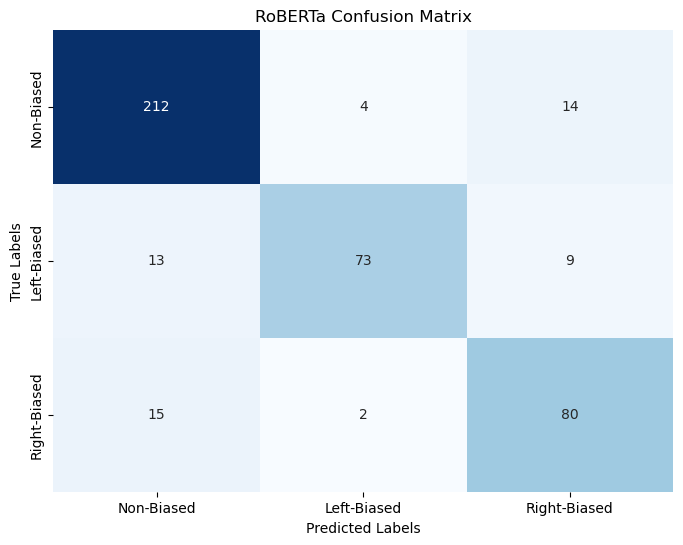

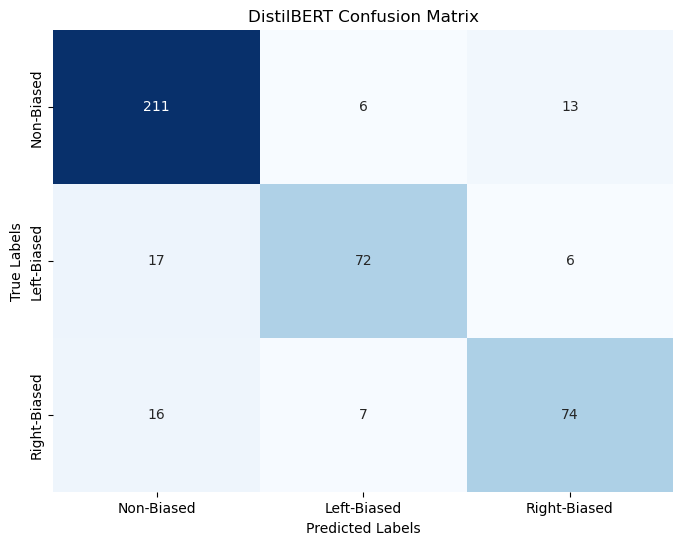

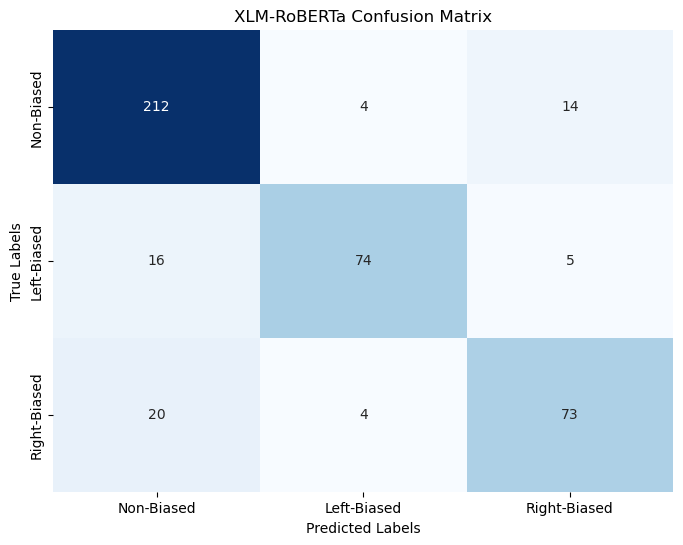

In [146]:
# Example labels and predictions (you should replace these with actual predictions from your Trainer output)
true_labels = Roberta_tokenized_datasets['test']['labels']


# Calculate ensemble scores and append results to the rows list
outputs = [RobertaOutput, DistilbertOutput, XLMRoBERTaOutput]
ensemble_score_labels_, acc, f1 = ensemble_score(outputs, Roberta_tokenized_datasets['test']['labels'])
ensemble_score_total_sum_labels, acc, f1 = ensemble_score_total_sum(outputs, XLM_RoBERTa_tokenized_datasets['test']['labels'])
weighted_ensemble_score_total_sum_labels, acc, f1 = ensemble_score_total_sum(outputs, XLM_RoBERTa_tokenized_datasets['test']['labels'], [0.6, 0.2, 0.2])

# Plotting for each model
class_names = ['Non-Biased', 'Left-Biased', 'Right-Biased']
plot_confusion_matrix(true_labels, RobertaOutput.predictions, title='RoBERTa Confusion Matrix', class_names=class_names)
plot_confusion_matrix(true_labels, DistilbertOutput.predictions, title='DistilBERT Confusion Matrix', class_names=class_names)
plot_confusion_matrix(true_labels, XLMRoBERTaOutput.predictions, title='XLM-RoBERTa Confusion Matrix', class_names=class_names)

### Conclusion

Throughout this project, we evaluated the performance of three different transformer-based models: RoBERTa, DistilBERT, and XLM-RoBERTa, on a multiclass classification task. Below are the observed accuracies for each model when tested on our dataset:

| Model           | Test Accuracy | F1-Score |
|-----------------|---------------|----------|
| **RoBERTa**     | **86.493%**       | **84.707%**  |
| **DistilBERT**  | 84.597%       | 82.308%  |
| **XLM-RoBERTa** | 85.071%       | 83.189%  |


To enhance the performance and leverage the strengths of each model, we implemented ensemble techniques. The accuracies achieved by these ensemble methods are:

| Ensemble Type                  | Test Accuracy | F1-Score |
|--------------------------------|---------------|----------|
| **Voting Ensemble**            | 86.256%       | 84.635%  |
| **Prediction Confidence Ensemble** | 86.256%   | 84.577%  |
|**Weighted Prediction Confidence Ensemble** |**86.493%**|**84.731%**|

The first two ensemble approaches (Voting and Prediction Confidence) effectively boosts the performance over the weakest model (DistilBERT), indicating that combining model predictions can help mitigate individual model weaknesses. However, it did not surpass the strongest model (RoBERTa). This can occur if the models make similar types of errors or if the strongest model already performs near an upper limit for the given data and model configurations. The overall of ensble is less than the best model as the lower performance of the other two models negatively impacted the overall performance.

The Weighted Prediction Confidence Ensemble, matched the accuracy  of the best individual model (RoBERTa) but improved on F1-score by around 0.03% which shows a slight performance improvement. This indicates that while ensembles can stabilize prediction outcomes, the improvements might be marginal depending on the variance and accuracy of the individual models involved.

This analysis suggests that for tasks where model interpretability is not critical, employing an ensemble of models could be beneficial, especially in scenarios where different models capture various aspects of the data differently. However, the overhead of maintaining multiple models versus the incremental gain in performance should also be considered.

Overall, the project demonstrates the effectiveness of transformer models in handling complex text classification tasks and the potential of ensembles to enhance predictive performance.


## 8. Ensembel Evaluation for Binary Classification

In [324]:
# Define headers and rows for the table
headers = ["Model", "SG1 Dataset F1-Score", "SG2 Dataset F1-Score"]
rows = [
    ["RoBERTa", SG1_RobertaTrainer_Output.metrics['test_eval_f1'], SG2_RobertaTrainer_Output.metrics['test_eval_f1']],
    ["DistilBERT", SG1_DistilbertTrainer_Output.metrics['test_eval_f1'], SG2_DistilbertTrainer_Output.metrics['test_eval_f1']],
    ["XLM-RoBERTa", SG1_XLM_RobertaTrainer_Output.metrics['test_eval_f1'], SG2_XLM_RobertaTrainer_Output.metrics['test_eval_f1']]
]

# Calculate ensemble scores and append results to the rows list
SG1_outputs = [SG1_RobertaTrainer_Output, SG1_DistilbertTrainer_Output, SG1_XLM_RobertaTrainer_Output]
SG2_outputs = [SG2_RobertaTrainer_Output, SG2_DistilbertTrainer_Output, SG2_XLM_RobertaTrainer_Output]
ensemble_score_labels_, acc, SG1_f1 = ensemble_score(SG1_outputs, SG1_XLM_Roberta_tokenized_dataset['test']['labels'])
ensemble_score_labels_, acc, SG2_f1 = ensemble_score(SG2_outputs, SG2_XLM_Roberta_tokenized_dataset['test']['labels'])
rows.append(["Voting Ensemble", SG1_f1, SG2_f1])

ensemble_score_labels_, acc, SG1_f1 = ensemble_score_total_sum(SG1_outputs, SG1_XLM_Roberta_tokenized_dataset['test']['labels'])
ensemble_score_labels_, acc, SG2_f1 = ensemble_score_total_sum(SG2_outputs, SG2_XLM_Roberta_tokenized_dataset['test']['labels'])
rows.append(["Prediction Confidence Ensemble", SG1_f1, SG2_f1])

weighted_ensemble_score_total_sum_labels, acc,SG1_f1 = ensemble_score_total_sum(SG1_outputs, SG1_XLM_Roberta_tokenized_dataset['test']['labels'], [0.6, 0.2, 0.2])
weighted_ensemble_score_total_sum_labels, acc,SG2_f1 = ensemble_score_total_sum(SG2_outputs, SG2_XLM_Roberta_tokenized_dataset['test']['labels'], [0.6, 0.2, 0.2])
rows.append(["Weighted Prediction Confidence Ensemble", SG1_f1, SG2_f1])

# Print the table using tabulate
print(tabulate(rows, headers=headers, tablefmt="simple"))


Model                                      SG1 Dataset F1-Score    SG2 Dataset F1-Score
---------------------------------------  ----------------------  ----------------------
RoBERTa                                                0.819167                0.806893
DistilBERT                                             0.774156                0.785058
XLM-RoBERTa                                            0.748219                0.779694
Voting Ensemble                                        0.767732                0.80703
Prediction Confidence Ensemble                         0.793333                0.796182
Weighted Prediction Confidence Ensemble                0.812779                0.804325
